In [178]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from matplotlib.dates import datestr2num
import torch.optim as optim
from sklearn import preprocessing
import math
from scipy.stats import gaussian_kde
from datetime import datetime
import random

In [223]:
RESULT_FILENAME = "_entry_results.csv"

# with open(RESULT_FILENAME, "a") as fd:
#     fd.write("time_of_run, ")
#     fd.write("BATCH_SIZE, TRAIN_SPLIT, NUM_FEATURES, NUM_UNITS, NUM_USERS, NUM_EPOCHS, ")
#     fd.write("EPSILON, DELTA, NORMCLIP, SIGMA, RHO, w_map, w_distortion, w_distance, w_density, w_ID, w_loc, ")
#     fd.write("MAP_PARAMS, NUM_GRIDS, ")
#     fd.write("AD_LAYERS, GAP_LAYERS, ")
#     fd.write("PRIVATIZER, ")
#     fd.write("train_a_loss, train_p_loss, ")
#     fd.write("u_estimate_acc, loc_estimate_error, ")
#     fd.write("test_a_loss, signal_map_error, distortion_error, loc_error, density_error")    
#     fd.write("\n")

In [180]:
FILENAME = 'augmented_data.csv'

BATCH_SIZE = 128
TRAIN_SPLIT = 0.7

NUM_FEATURES = 24
NUM_UNITS = 32
NUM_USERS = 9
NUM_EPOCHS = 1

EPSILON = 0.01
DELTA = 0.00001
NORM_CLIP=7.154

SIGMA = 1.0

RHO = 0.001
# rho of 1 is all utility, 0 is all privacy
UTILITY_WEIGHTS = (2,1,1,1)
PRIVACY_WEIGHTS =(1,1)

MAP_PARAMS = 2

NUM_GRIDS = 4

with open(RESULT_FILENAME,"a") as fd:
    fd.write(str(datetime.now()))
    fd.write(", ")
    for elt in [BATCH_SIZE, TRAIN_SPLIT, 
                NUM_FEATURES, NUM_UNITS, NUM_USERS, NUM_EPOCHS, 
                EPSILON, DELTA, NORM_CLIP, SIGMA, RHO, UTILITY_WEIGHTS[0], UTILITY_WEIGHTS[1], 
                UTILITY_WEIGHTS[2], UTILITY_WEIGHTS[3], PRIVACY_WEIGHTS[0], PRIVACY_WEIGHTS[1],
                MAP_PARAMS, NUM_GRIDS]:
        fd.write(str(elt))
        fd.write(", ")

## Load Data

In [181]:
userID = {
'a841f74e620f74ec443b7a25d7569545':0,
'22223276ea84bbce3a62073c164391fd':1,
'510635002cb29804d54bff664cab52be':2,
'7cbc37da05801d46e7d80c3b99fd5adb':3,
'7023889b4439d2c02977ba152d6f4c6e':4,
'8425a81da55ec16b7f9f80c139c235a2':5,
'6882f6cf8c72d6324ba7e6bb42c9c7c2':6,
'1e33db5d2be36268b944359fbdbdad21':7,
'892d2c3aae6e51f23bf8666c2314b52f':8,
}

In [182]:
class ChaniaDataset(Dataset):
    def __init__(self, csv_file, transform=None, normalize=True):
        self.augmented_data = pd.read_csv(csv_file, header=0, usecols = [0]+list(range(2,21))+list(range(22,26)), 
                                          converters={0:lambda x: datestr2num(x)})
        self.userlabels = pd.read_csv(csv_file, header=0, usecols=["iPhoneUID"],converters={"iPhoneUID": lambda x: userID[x]})
        self.transform = transform
        
        if normalize:
            self.augmented_data=(self.augmented_data-self.augmented_data.mean())/self.augmented_data.std()

    def __len__(self):
        return len(self.augmented_data)

    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        data = self.augmented_data.iloc[idx].values
        data = data.astype('float').reshape(-1,NUM_FEATURES)            
        user = self.userlabels.iloc[idx].values
        user = user.astype('int').reshape(-1,1)
        sample = {'x':data, 'u':user}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [183]:
class ToTensor(object):
    def __call__(self, sample):
        data, user = sample['x'], sample['u']
        return {'x':torch.from_numpy(data), 'u':torch.from_numpy(user)}

In [184]:
# chania_dataset = ChaniaDataset(csv_file=FILENAME, transform=ToTensor(), normalize=True)

In [185]:
train_size=int(TRAIN_SPLIT*len(chania_dataset))
test_size = len(chania_dataset)-train_size

In [186]:
train_dataset, test_dataset = torch.utils.data.random_split(chania_dataset, [train_size, test_size])

In [187]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

DP privately calculate clipping

In [188]:
# def dp_count(dataset,clip):
#     count = 0
#     for row in range(len(dataset.values)):
#         if np.random.random() > 0.5:
#             if np.linalg.norm(dataset.values[row]) >= clip:
#                 count += 1
# #         elif np.random.random() > 0.5:
# #             count += 1
# #     real_count = .75*count
#     real_count = count*2
#     return 100*real_count/len(dataset.values)

In [189]:
# def non_dp_count(dataset,clip):
#     count = 0
#     for row in range(len(dataset.values)):
#         if np.random.random() > 0:
#             if np.linalg.norm(dataset.values[row]) >= clip:
#                 count += 1
#         elif np.random.random() < 0:
#             count += 1
#     real_count = 1*count
#     return 100*real_count/len(dataset.values)

In [190]:
# dp_count(chania_dataset.augmented_data,7.154)

In [191]:
# non_dp_count(chania_dataset.augmented_data,7)

## Visualize Functions

In [192]:
def show_batch_wlabels(sample_batch,longlines=None,latlines=None):
    with torch.no_grad():
        data, users = sample_batch['x'], sample_batch['u']
        batch_size = len(data)
        colors = users.numpy()[:,0].tolist()
        for i in range(batch_size):
            plt.scatter(data[:,:,13].numpy(), data[:,:,12].numpy(), c=colors)
        if longlines is not None:
            for line in longlines.numpy():
                plt.axvline(line)
        if latlines is not None:
            for line in latlines.numpy():
                plt.axhline(line)

In [193]:
def show_privatizer(x, y, u, uhat, lochat):
    with torch.no_grad():
        fig, ax = plt.subplots(1,3,figsize=(17,5))
        #sharex=True,sharey=True,
        ax[0].set_title("Input Data")
        ax[1].set_title("Obfuscated Data")
        ax[2].set_title("Adversary Estimate")
        ax[0].scatter(x[:,:,13].numpy(),x[:,:,12].numpy(),c=u.unsqueeze(0).numpy().T.tolist())
        ax[1].scatter(y[:,:,13].numpy(),y[:,:,12].numpy())
        _, upred = torch.max(uhat.data,1)
        ax[2].scatter(lochat[:,1].numpy(), lochat[:,0].numpy(),c=upred.numpy())
        for axis in ax:
            axis.set_xlabel("longitude (normalized)")
            axis.set_ylabel("latitude (normalized)")

In [194]:
def show_maps(x, y,npoints=100):
    with torch.no_grad():
        fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(15,5))
        ax[0].set_title("Map from Input Data")
        ax[1].set_title("Map from Obfuscated Data")
        
        grid = torch.empty(npoints,1,2).uniform_(5)-2.5
        tr = [grid[:,:,1]**i*grid[:,:,0]**(degree-i) for degree in range(MAP_PARAMS+1) for i in range(degree,-1,-1)]
        poly_grid = torch.cat(tr,1)
        poly_grid = poly_grid.view(-1,6)
        
        bx = signal_map_params(x,MAP_PARAMS).float()
        by = signal_map_params(y,MAP_PARAMS).float()  
        x_predicted_rss = torch.mm(poly_grid,bx)
        y_predicted_rss = torch.mm(poly_grid,by)
        
        ax[0].scatter(grid[:,:,1].numpy(),grid[:,:,0].numpy(),c=x_predicted_rss.numpy())
        ax[1].scatter(grid[:,:,1].numpy(),grid[:,:,0].numpy(),c=y_predicted_rss.numpy())

## Define loss and helper functions

In [195]:
def privatizer_loss(x,y,u,uhat):
    bx = signal_map_params(x,MAP_PARAMS)
    by = signal_map_params(y,MAP_PARAMS)
    l1 = (bx-by).pow(2).mean()
    l2 = (x-y).pow(2).mean()
    l3 = (y[:,:,12:14]-x[:,:,12:14]).pow(2).mean()
    cx,_,_ = density_count(x,NUM_GRIDS)
    cy,_,_ = density_count(y,NUM_GRIDS)
    l4 = (cx-cy).pow(2).mean()/BATCH_SIZE
    if u is not None:
        l = torch.nn.CrossEntropyLoss()
        l5 = l(uhat,u)
        l6 = density_loss(x,y)
        w1,w2,w3,w4 = UTILITY_WEIGHTS
        total_loss = RHO*(w1*l1+w2*l2+w3*l3+w4*l6)-(1-RHO)*l5
        return 10*total_loss
    else: # if not given adversary estimate, just utility losses
        l6 = density_loss(x,y)
        w1,w2,w3,w4 = UTILITY_WEIGHTS
        total_loss = RHO*(w1*l1+w2*l2+w3*l3+w4*l6)
        return 10*total_loss

In [196]:
def poly(degree, long, lat):
    return torch.cat([long**i*lat**(degree-i) for degree in range(MAP_PARAMS+1) for i in range(degree,-1,-1)],1)

def signal_map_params(x,degree):    
    polynomial = poly(MAP_PARAMS, x[:,:,13], x[:,:,12])
    beta = torch.mm(torch.inverse(torch.mm(torch.transpose(polynomial,0,1), polynomial)),
                  torch.mm(torch.transpose(polynomial,0,1), x[:,:,6]))
    return beta

In [197]:
def density_count(x, num_grids):
    count = torch.zeros(num_grids,num_grids)
    x1min=torch.min(x[:,:,13])
    x2min=torch.min(x[:,:,12])
    size1 = torch.max(x[:,:,13])-x1min
    size2 = torch.max(x[:,:,12])-x2min
    a_all = []
    c_all = []
    for i in range(num_grids):
        for j in range(num_grids):
            a = x1min+(size1/num_grids*i)
            a_all.append(a)
            b = x1min+(size1/num_grids*(i+1))
            a_all.append(b)
            c = x2min+(size2/num_grids*j)
            c_all.append(c)
            d = x2min+(size2/num_grids*(j+1))
            c_all.append(d)
            if i == num_grids-1 and j != num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] <= b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] < d)].size(0)
            elif j == num_grids-1 and i != num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] < b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] <= d)].size(0)
            elif j == num_grids-1 and i == num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] <= b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] <= d)].size(0)
            else:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] < b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] < d)].size(0)
    return count, torch.unique(torch.Tensor(a_all)), torch.unique(torch.Tensor(c_all))

In [198]:
def density_loss(x,y):
    a = (100*torch.clamp(x[:,:,12],0,0.01).sum() - 100*torch.clamp(y[:,:,12],0,0.01).sum())**2
    b = (-100*torch.clamp(x[:,:,12],-0.01,0).sum() - -100*torch.clamp(y[:,:,12],-0.01,0).sum())**2
    c = (100*torch.clamp(x[:,:,13],0,0.01).sum() - 100*torch.clamp(y[:,:,13],0,0.01).sum())**2
    d = (-100*torch.clamp(x[:,:,13],-0.01,0).sum() - -100*torch.clamp(y[:,:,13],-0.01,0).sum())**2
    return (a+b+c+d)/BATCH_SIZE

In [199]:
def adversary_loss(u,x,uhat,lochat):
    l = torch.nn.CrossEntropyLoss()
    dist = (x[:,:,12:14].squeeze()-lochat).pow(2).mean()
    # spread = (x[:,:,12:14].squeeze().std(dim=0)-lochat.std(dim=0)).pow(2).mean()
    w1, w2 = PRIVACY_WEIGHTS
    return w1*l(uhat,u)+w2*dist

## Define adversary

In [200]:
# with open(RESULT_FILENAME, "a") as fd:
#     fd.write("3, ")

In [201]:
adversary = torch.nn.Sequential(
    torch.nn.Linear(NUM_FEATURES, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
#     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
#     torch.nn.ReLU(),
#     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
#     torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_USERS+2)
)
# adversary.apply(init_weights)
adversary.double()

Sequential(
  (0): Linear(in_features=24, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=11, bias=True)
)

In [202]:
adversary_optimizer = optim.Adam(adversary.parameters(),lr=0.001, betas=(0.9,0.999))

## Define privatizers

#### GAP

In [203]:
# with open(RESULT_FILENAME, "a") as fd:
#     fd.write("3, ")

In [204]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0, std=0.3)
        # m.bias.data.fill_(2)

In [205]:
gap_privatizer = torch.nn.Sequential(
    torch.nn.Linear(NUM_FEATURES, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
#     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
#     torch.nn.ReLU(),
#     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
#     torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_FEATURES)
)
gap_privatizer.apply(init_weights)
gap_privatizer.double()
gap_privatizer_optimizer = optim.Adam(gap_privatizer.parameters(),lr=0.002, betas=(0.9,0.999))

#### Local DP

In [206]:
def analytical_gaussian_sigma(eta, epsilon, delta):
    def phi(x):
        return 1/2*(1+math.erf(x/math.sqrt(2)))
    delta_0 = phi(0)-math.e**epsilon*phi(-math.sqrt(2*epsilon))
    def Bplus(v):
        return phi(math.sqrt(epsilon*v))-math.e**epsilon*phi(-math.sqrt(epsilon*(v+2)))
    def Bminus(v):
        return phi(-math.sqrt(epsilon*v))-math.e**epsilon*phi(-math.sqrt(epsilon*(v+2)))
    if delta >= delta_0:
        vstar = 0
        while Bplus(vstar) <= delta:
            vstar += 1
            if vstar == 1000000:
                return 0
        alpha = math.sqrt(1+vstar/2)-math.sqrt(vstar/2)
    else:
        ustar = 0
        while Bminus(ustar) > delta:
            ustar += 1
        alpha = math.sqrt(1+ustar/2)+math.sqrt(ustar/2)
    sigma = alpha*eta/math.sqrt(2*epsilon)
    return sigma

def dp_privatizer(x,s):
    normvec = torch.norm(x,p=2,dim=2)
    scalevec = NORM_CLIP/normvec
    scalevec[scalevec>1] = 1
    x = torch.transpose(torch.transpose(x,0,1)*scalevec,0,1).double()
    noise = torch.normal(mean=torch.zeros_like(x),std=s).double()
    y = x + noise
    return y

#### Gaussian Noise

In [207]:
def noise_privatizer(x):
    noise = torch.normal(mean=torch.zeros_like(x),std=SIGMA).double()
    y = x + noise
    return y

#### Mutual Info Privatizer

In [208]:
CODEBOOK_SIZE = 1
UTILITY_CONSTRAINT = 0.2
PROB_DISTR = gaussian_kde(chania_dataset.augmented_data.values.T)
codebook = {}
for i in range(CODEBOOK_SIZE):
    y = PROB_DISTR.resample(128).T
    y = torch.DoubleTensor(y.reshape(BATCH_SIZE,1,NUM_FEATURES))    
    codebook[y] = None

In [239]:
def MI_privatizer(x, codebook):
    for y in codebook.keys():
        codebook[y] = privatizer_loss(x,y,None,None)
    best = random.choices(list(codebook.keys()), codebook.values())[0]
    return best, codebook[best]

# TRAIN

In [240]:
PRIVATIZER = MI_privatizer

In [241]:
# with open(RESULT_FILENAME, "a") as fd:
#     if PRIVATIZER == gap_privatizer:
#         fd.write(' gap_privatizer')
#         fd.write(", ")
#     else:
#         fd.write(str(PRIVATIZER))
#         fd.write(", ")
#     #fd.write(' test, ')

In [242]:
sigma = analytical_gaussian_sigma(NORM_CLIP, EPSILON, DELTA)

# for each epoch
for epoch in range(NUM_EPOCHS):
    
    count = 0
    # iterate through the training dataset
    for i, batch in enumerate(train_loader):
        
        # unpack batch
        x, u = batch['x'], batch['u'].squeeze()
        
        if PRIVATIZER == gap_privatizer:
            # reset privatizer gradients
            gap_privatizer_optimizer.zero_grad()
        
        # privatize x
        if PRIVATIZER == MI_privatizer:
            y, ploss = MI_privatizer(x, codebook)
            if ploss > UTILITY_CONSTRAINT:
                count += 1
#             ebreak = 0
#             while ploss >= UTILITY_CONSTRAINT and ebreak < 1000:
#                 ebreak += 1
#                 y = zero_MI_privatizer(PROB_DISTR)
#                 ploss = privatizer_loss(x,y, None, None)
#             if ebreak == 1000:
#                 count += 1
                
        elif PRIVATIZER == dp_privatizer:
            y = dp_privatizer(x,sigma)
        else:
            y = PRIVATIZER(x)
        
        # reset adversary gradients
        adversary_optimizer.zero_grad()
        
        # estimate userIDs and original locations
        estimate = adversary(y).squeeze()
        uhat, lochat = estimate[:,:9], estimate[:,9:]
        
        # train adversary
        aloss = adversary_loss(u,x,uhat,lochat)
        aloss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(adversary.parameters(), 1000)
        adversary_optimizer.step()
        
        # evaluate utility loss
        ploss = privatizer_loss(x,y,u,uhat)
        
        if PRIVATIZER == gap_privatizer:
            # train privatizer
            ploss.backward()
            torch.nn.utils.clip_grad_norm_(gap_privatizer.parameters(), 1000)
            gap_privatizer_optimizer.step()
        
        # print progress
        if i % 500 == 499:
            print(i+1,"aloss:",aloss.item(),"ploss:",ploss.item())
          
        # stop early
        if i == 10:
            pass
        if i == 2434:
            break
print("done")
if PRIVATIZER == MI_privatizer:
    print(count, "out of", i, "failed to meet utility constraint")

with torch.no_grad():
    with open(RESULT_FILENAME, "a") as fd:
        fd.write(str(aloss.item()))
        fd.write(", ")
        fd.write(str(ploss.item()))
        fd.write(", ")

500 aloss: 2.6563760513614008 ploss: -16.455652557059246
1000 aloss: 2.8827928109864516 ploss: -16.922172683538165
1500 aloss: 2.511377699741299 ploss: -16.870302717453644
2000 aloss: 2.6637279969598304 ploss: -16.98864080818245
done
813 out of 2434 failed to meet utility constraint


# Test

In [213]:
test_epochs=1

# do not keep track of gradients
with torch.no_grad():
    correct = 0
    total = 0
    dist_error = 0
    l1,l2,l3,l4,l5,l6 = 0,0,0,0,0,0
    
    # iterate through test data
    for i,batch in enumerate(test_loader):
        
        for epoch in range(test_epochs):
        
            # unpack batch
            x, u = batch['x'], batch['u'].squeeze()

            # privatize x
            if PRIVATIZER == MI_privatizer:
                y, ploss = MI_privatizer(x, codebook)
            elif PRIVATIZER == dp_privatizer:
                y = dp_privatizer(x,sigma)
            else:
                y = PRIVATIZER(x)

            # estimate userID and location
            estimate = adversary(y).squeeze()
            uhat, lochat = estimate[:,:9], estimate[:,9:]

            # Privacy Metric
            _, upred = torch.max(uhat.data,1)
            total+=u.size(0)
            correct+=(upred==u).sum().item()
            dist_error += (x[:,:,12:14].squeeze()-lochat).pow(2).mean().item()

            # Utility Metrics
            l = torch.nn.CrossEntropyLoss()
            l5 += l(uhat,u).item()
            bx = signal_map_params(x,MAP_PARAMS)
            by = signal_map_params(y,MAP_PARAMS)
            l1 += (bx-by).pow(2).mean().item()
            l2 += (y-x).pow(2).mean().item()
            l3 += (y[:,:,12:14]-x[:,:,12:14]).pow(2).mean().item()
            cx,_,_ = density_count(x,NUM_GRIDS)
            cy,_,_ = density_count(y,NUM_GRIDS)
            l4 += (cx-cy).pow(2).mean().item()/BATCH_SIZE
            l6 += density_loss(x,y).item()

        # stop early
        if i == 100:
            pass
        if i == 1042:
            break
            
    if PRIVATIZER == gap_privatizer:
        print("RHO=",RHO)
    elif PRIVATIZER == noise_privatizer:
        print("SIGMA=",SIGMA)
    elif PRIVATIZER == dp_privatizer:
        print("EPSILON=",EPSILON,"DELTA=",DELTA,"NORM_CLIP=",NORM_CLIP)
    elif PRIVATIZER == MI_privatizer:
        print("CODEBOOK SIZE=", CODEBOOK_SIZE)
        print("UTILITY CONSTRAINT=", UTILITY_CONSTRAINT)
    print("")
        
    print("Adversary Accuracy:", 100*correct/total)
    print("Average estimated location error:",dist_error/(i+1))
    print("")
    
    print("Adversary Loss:", l5/(i+1)/test_epochs)
    print("Signal Map:", l1/(i+1)/test_epochs)
    print("Distortion:", l2/(i+1)/test_epochs)
    print("Geographic Distortion:", l3/(i+1)/test_epochs)
    print("Density Count:",l4/(i+1)/test_epochs)
    print("Density Approx:",l6/(i+1)/test_epochs)
    
    with open(RESULT_FILENAME, "a") as fd:
        for elt in [100*correct/total, dist_error/(i+1)/test_epochs, l5/(i+1)/test_epochs, 
                    l1/(i+1)/test_epochs, l2/(i+1)/test_epochs, l3/(i+1)/test_epochs]:
            fd.write(str(elt))
            fd.write(", ")
        fd.write(str(l4/(i+1)))
        fd.write("\n")

CODEBOOK SIZE= 1
UTILITY CONSTRAINT= 0.2

Adversary Accuracy: 32.35783197507191
Average estimated location error: 0.9935963338656993

Adversary Loss: 1.6941233799058442
Signal Map: 0.06745709663827985
Distortion: 2.5327086118582596
Geographic Distortion: 2.5683852707005856
Density Count: 1.0428067698346117
Density Approx: 13.280931015866514


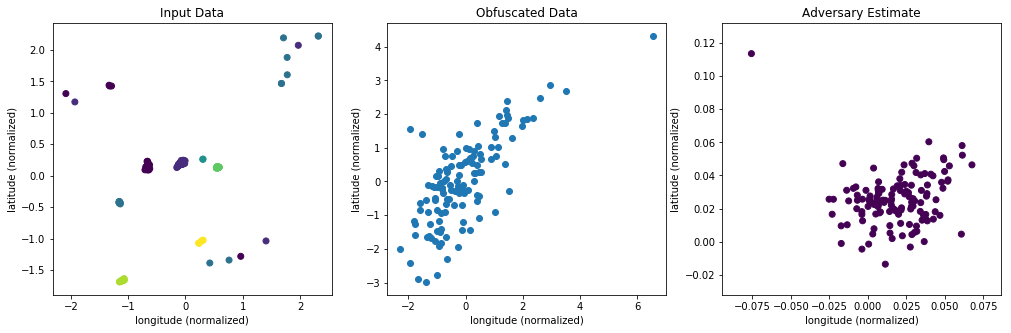

In [214]:
with torch.no_grad():
    show_privatizer(x,y,u,uhat,lochat)

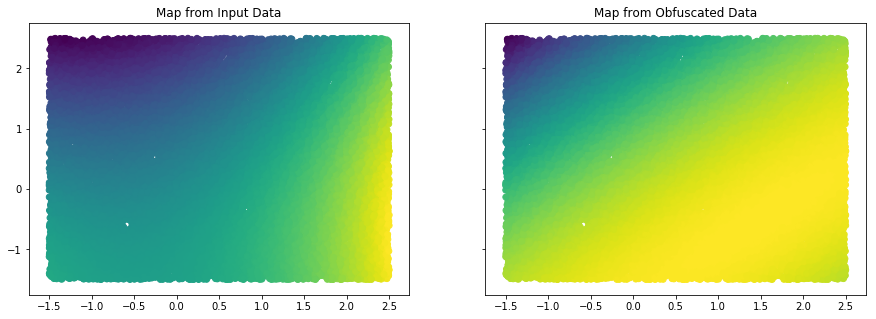

In [215]:
with torch.no_grad():
    show_maps(x,y,20000)

In [216]:
# with open(RESULT_FILENAME, "a") as fd:
#     fd.write("\n")

In [217]:
# c = chania_dataset[:]['x'].numpy().squeeze()[:,12:14][0:50]
# c2 = chania_dataset[:]['x'].numpy().squeeze()[:,12:14][1000:1050]

In [218]:
# density_distr = gaussian_kde(c.T)
# density_distr2 = gaussian_kde(c2.T)

In [219]:
# density_distr.integrate_kde(density_distr2)

In [220]:
# density_distr2.integrate_kde(density_distr)

In [221]:
# chania_dataset[:]['x'].numpy().squeeze()[:,12:14][0:20]

In [222]:
# a = torch.Tensor([1.0,2.0])
# b = torch.Tensor([2.0,1.0])
# torch.nn.functional.kl_div(a.log(),b,reduction='sum')